![nawa](https://nawa.gov.pl/images/rozszerzenia/szablony/siteb3/logo-komputer.png)

**WORKSHOP ON HYPERGRAPH MODELLING** @ 17th Workshop on Algorithms and Models for the Web Graph

Prof. _Gennaro Cordasco_

## Target set selection heuristics
Three greedy-based heuristics for the **Diffusion on Hypergraphs** problem,
i.e. finding the minimum influence target set *S in V* of a hypergraph *H=(V,E)*
able to influence the whole network.

## Compute the target set according to the following algorithm.

**_Dynamic greedy heuristic on hypergraph 2-section view_**

The degree of nodes is computed on the [H]₂ of the residual hypergraph Hⁱ of *H*.
Hⁱ is the hypergraph obtained by removing all hyperedges that are already influenced
by the nodes in *S* at stage *i*.


In [5]:
function dynamic_greedy_2section(h, metaV, metaE)
    S = Dict{Int,Int}()
    U = Dict{Int,Int}()

    #init U set
    for v=1:nhv(h)
        heus = gethyperedges(h,v)
        d = Set{Int}()
        for he in heus
            push!.(Ref(d),keys(getvertices(h,he.first)))
        end
        push!(U, v => length(d))
    end

    while length(U) != 0
		 maxv_val, maxv_key = findmax(U)
         delete!(U, maxv_key)
         S[maxv_key] = maxv_val
         actE = zeros(Bool, nhe(h))
         actV = zeros(Bool, nhv(h))
         for s in S
              actV[s.first] = true
         end
	     simres = simulate!(h, actV, actE, metaV, metaE; printme = false)

         if simres.actvs == nhv(h)
             break
         end

         visited = Set{Int}()
         for he in gethyperedges(h, maxv_key)

             for nv in getvertices(h,he.first)

                 if !haskey(U,nv.first) || nv.first in visited
                     continue
                 end
                 push!(visited, nv.first)

                 d = Set{Int}()
                 for he2 in gethyperedges(h, nv.first)
                     if ! actE[he2.first]
                         push!.(Ref(d), keys(getvertices(h, he2.first)))
                     end
                 end
                 U[nv.first] = length(d)
             end
         end


    end
    length(S)
end
;

_**Binary search based heuristic on hypergraph**_

In [7]:

function static_greedy(h, metaV, metaE)
    degrees = length.(h.v2he)
    sortedVind = sortperm(degrees, rev=true)

    left = 1
    @assert length(sortedVind) == length(degrees)
    right = length(sortedVind)
    while left < right
        location = Int(ceil( (left + right)/2))
        actE = zeros(Bool, nhe(h))
        actV = zeros(Bool, nhv(h))
        # up to the first location true and remainder zeros
        actV[sortedVind[1:location]] .= true
        sres = simulate!(h, actV, actE, metaV, metaE; printme = false)
        if sres.actvs != nhv(h)
            left = location
        else
            right = location-1
        end
    end
    left+1
end
;

**_Dynamic greedy heuristic on hypergraph_**

Initially, all nodes are added to the candidates set *U*.
At each stage, the node of maximum degree is added to the target set *S* and removed from *U*.
At this point, some nodes and/or hyperedges become infected.

The algorithm simulates the diffusion process, and the influenced edges are pruned from the network.
Consequentially, the degree of nodes δ(v) is updated.

In [8]:

function dynamic_greedy(h, metaV, metaE)

    S = Dict{Int,Int}()
    U = Dict{Int,Int}()

    #init U set
    for v=1:nhv(h)
        heus = gethyperedges(h,v)
        d = 0
        for he in heus
                d+=1
        end
        push!(U, v => d)
    end

    while length(U) != 0
         #maxv = sort!(collect(U), by=x->x[2], rev = true)[1]
		 maxv_val, maxv_key = findmax(U)
         delete!(U, maxv_key)
         S[maxv_key] = maxv_val
         actE = zeros(Bool, nhe(h))
         actV = zeros(Bool, nhv(h))

         for s in S
              actV[s.first] = true
         end

         simres = simulate!(h, actV, actE, metaV, metaE; printme = false)

         if simres.actvs == nhv(h)
             break
         end

         for he in gethyperedges(h,maxv_key)
             for nv in getvertices(h,he.first)
                 if !haskey(U,nv.first)
                     continue
                 end
                 d = 0
                 for he2 in gethyperedges(h, nv.first)
                     if ! actE[he2.first]
                         d+=1
                     end
                 end

                 push!(U, nv.first => d)

             end
         end


    end

    actE = zeros(Bool, nhe(h))
    actV = zeros(Bool, nhv(h))

    for s in S
         actV[s.first] = true
    end

    simres = simulate!(h, actV, actE, metaV, metaE; printme = false)

    if simres.actvs != nhv(h)
        println("Some problems here ", simres.actvs, " ", nhv(h))
    end

    length(S)
end
;

## Utility functions

**_Simulation function._** It simulates the spreading of influence in a hypergraph, considering the nodes and hyperedges thresholds.

In [21]:
function simulate!(
        h::Hypergraph{Bool},
        actV::Vector{Bool}, actE::Vector{Bool},
        metaV::Vector{Int}, metaE::Vector{Int};
        printme = true, max_step=1_000_000 
    )
    step = 0
    while true && step < max_step
        step += 1
        actE_cp = deepcopy(actE)
        #deb = DataFrame(step=Int[], aSum)
        for e in 1:nhe(h)
            aSum = sum(actV[ collect(keys(getvertices(h,e))) ])
            if aSum >= metaE[e]
                actE_cp[e] = true
            end
            printme && println("$step e=$e $aSum $(metaE[e]) $(actE_cp[e])")
        end
        #sum(actE_cp) == sum(actE) && return (actvs = sum(actV), step=step-1)
        actE .= actE_cp
        actV_cp = deepcopy(actV)
        for v in 1:nhv(h)
            aSum = sum(actE[ collect(keys(gethyperedges(h,v))) ])
            if aSum >= metaV[v]
                actV_cp[v] = true
            end
            printme && println("$step v=$v $aSum $(metaV[v]) $(actV_cp[v])")
        end
        sum(actV_cp) == sum(actV) && return (actvs = sum(actV), step=step-1)
        actV .= actV_cp
    end
    step
end
;

**_Generate nodes thresholds proportionally to the degree._**

In [17]:
function proportionalMetaV(h::Hypergraph,prop)
    @assert 0.0 < prop <= 1.0
    metaV = Vector{Int}(undef, nhv(h))
    for v in 1:nhv(h)
        metaV[v] = ceil(length(h.v2he[v])*prop)
    end
    metaV
end
;

**_ Generate hyperedges thresholds proportionally to the size._**

In [18]:
function proportionalMetaE(h::Hypergraph,prop)
    @assert 0.0 < prop <= 1.0
    metaE = Vector{Int}(undef, nhe(h))
    for e in 1:nhe(h)
        metaE[e] = ceil(length(h.he2v[e])*prop)
    end
    metaE
end
;

## Experiment

Here, we will evaluate the above heuristics with a hypergraph describing the interaction between the Game of Thrones TV series characters. 

First, we load a hypergraph studying characters' co-occurences within seasons. Here, the hyperedges are the GoT seasons and the characters who appear in each eason are the nodes.

In [35]:
using Pkg

In [42]:
pkg"add SimpleHypergraphs Statistics PyPlot LaTeXStrings"
;

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [43]:
using SimpleHypergraphs
using Statistics
using PyPlot
using LaTeXStrings

In [48]:
file = download(
    "https://raw.githubusercontent.com/spagnuolocarmine/spagnuolocarmine.github.io/master/assets/files/share/got.hgf",
    "got.hgf"
);

In [49]:
h = hg_load("got.hgf");

In [26]:
nvalues = range(0.1, stop=0.9, step=0.1)
runs = 10;

In [27]:
data = Dict{String, Vector{Vector{Int}}}()

push!(data, "BinarySearch(H)" => Vector{Vector{Int}}())
push!(data, "Greedy(H)" => Vector{Vector{Int}}())
push!(data, "Greedy([H]₂)" => Vector{Vector{Int}}())

Dict{String,Array{Array{Int64,1},1}} with 3 entries:
  "Greedy([H]₂)"    => Array{Int64,1}[]
  "BinarySearch(H)" => Array{Int64,1}[]
  "Greedy(H)"       => Array{Int64,1}[]

After, we run each heuristics on the obtained hypergraph.

In [28]:
for n=nvalues

    results1 = Vector{Int}()
    results2 = Vector{Int}()
    results3 = Vector{Int}()

    for run=1:runs
        metaV = proportionalMetaV(h, n)
        metaE = proportionalMetaE(h, 0.5)

        r1 = dynamic_greedy_2section(h, metaV, metaE)
        r2 = static_greedy(h, metaV, metaE)
        r3 = dynamic_greedy(h, metaV, metaE)

        push!(results1, r1)
        push!(results2, r2)
        push!(results3, r3)
    end
    push!(data["Greedy([H]₂)"], results1)
    push!(data["BinarySearch(H)"], results2)
    push!(data["Greedy(H)"], results3)

    println("end ", n)
end

end 0.1
end 0.2
end 0.3
end 0.4
end 0.5
end 0.6
end 0.7
end 0.8
end 0.9


## Plotting the results

In [50]:
labels_dict = Dict{String, String}(
    "BinarySearch(H)" => "StaticGreedy",
    "Greedy(H)" => "DynamicGreedy",
    "Greedy([H]₂)" => L"DynamicGreedy_{[H]_2}",
)

Dict{String,String} with 3 entries:
  "Greedy([H]₂)"    => "\$DynamicGreedy_{[H]_2}\$"
  "BinarySearch(H)" => "StaticGreedy"
  "Greedy(H)"       => "DynamicGreedy"

In [51]:
ticks = nvalues

0.1:0.1:0.9

In [61]:
clf()

plt.figure(figsize=(7,5))

val = -0.4
c = 1

colorz=["#2C7BB6", "#D7191C", "#FF8900"]

3-element Array{String,1}:
 "#2C7BB6"
 "#D7191C"
 "#FF8900"

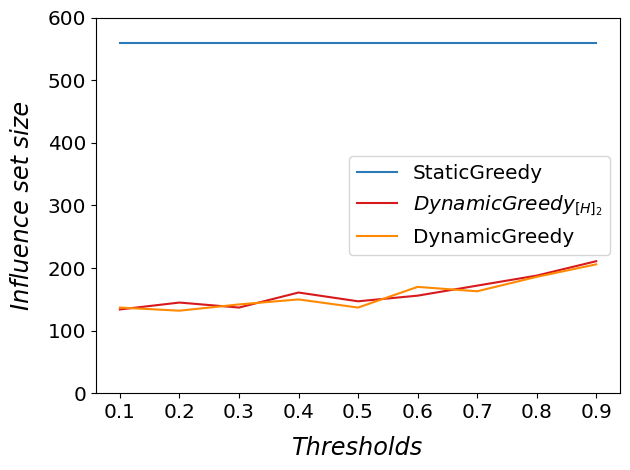

In [62]:
labels = Array{String, 1}()

for algo in ["BinarySearch(H)", "Greedy([H]₂)", "Greedy(H)"]
    global val, c

    y = Array{Float64, 1}()

    for v=1:length(collect((nvalues)))
        push!(y, mean(data[algo][v]))
    end

    push!(
        labels,
        labels_dict[algo]
    )

    b = plt.plot(collect(nvalues), y, color=colorz[c])

    c+=1
end

plt.legend(labels, fontsize="x-large")

plt.xticks(ticks, fontsize="x-large") 
plt.yticks(fontsize="x-large")

plt.ylim(0, 600)

ylabel("Influence set size", fontstyle = "italic", fontsize="xx-large", labelpad=10) 
xlabel("Thresholds", fontstyle = "italic", fontsize="xx-large", labelpad=10) 

plt.tight_layout()